In [1]:
import sys, os
sys.path.append("C:/Users/pjsin/Documents/cantera/build/python")
import cantera as ct
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import scipy.optimize
from scipy.optimize import curve_fit
import numpy as np
from matplotlib import gridspec

hfont = {'fontname':'sans-serif','fontweight':550,'fontsize':10,'fontstretch':500}

### 1)      CREATING THE CHEMICAL MECHANISM FILE AND DEFINING LMRR PARAMETERS FOR PRESSURE-DEPENDENT REACTIONS

#### 1.1) Reaction 10: O + O (+M) <=> O2 (+M)
* Changed the efficiency of ‘Ar’ to 1.0

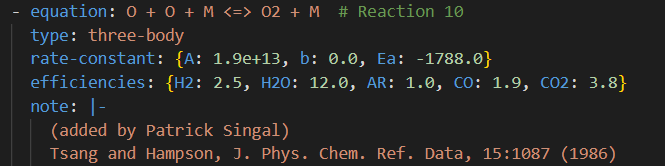

#### 1.2) Reaction 13: H + O2 (+M) <=> HO2 (+M)

Final table created from calculations:

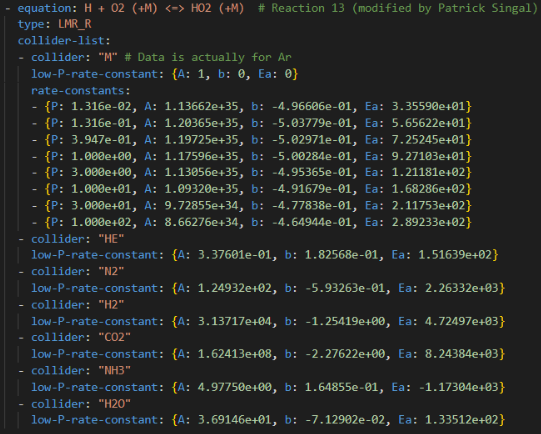

- {P: 1.316e-02, A: 1.13662e+35, b: -4.96606e-01, Ea: 3.35590e+01}
- {P: 1.316e-01, A: 1.20365e+35, b: -5.03779e-01, Ea: 5.65622e+01}
- {P: 3.947e-01, A: 1.19725e+35, b: -5.02971e-01, Ea: 7.25245e+01}
- {P: 1.000e+00, A: 1.17596e+35, b: -5.00284e-01, Ea: 9.27103e+01}
- {P: 3.000e+00, A: 1.13056e+35, b: -4.95365e-01, Ea: 1.21181e+02}
- {P: 1.000e+01, A: 1.09320e+35, b: -4.91679e-01, Ea: 1.68286e+02}
- {P: 3.000e+01, A: 9.72855e+34, b: -4.77838e-01, Ea: 2.11753e+02}
- {P: 1.000e+02, A: 8.66276e+34, b: -4.64944e-01, Ea: 2.89233e+02}


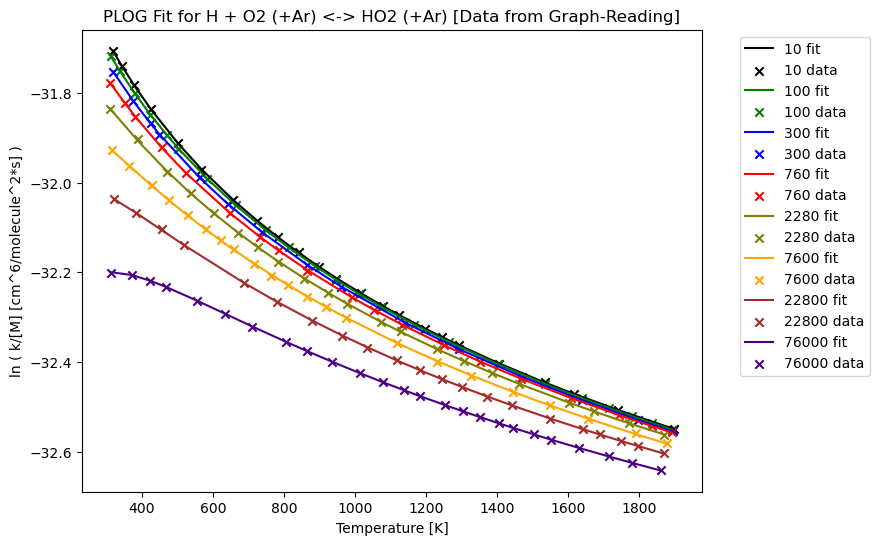

In [26]:
#STEP 1: PERFORM A PLOG FIT FOR AR COLLIDER, USING GRAPH-READ DATA FROM FIGURE 5 OF SJK PAPER
def arrhenius(T, A, n, Ea):
    return np.log(A) + n*np.log(T)+ (-Ea/(1.987*T))
pltcolours = ['k','g','b','r','olive','orange','brown','indigo']
path="G:\\Mon disque\\Columbia\\Burke Lab\\01 Mixture Rules Project\\"
fname=path+"rateConstantCalculations_SKJFig5.csv"
plt.figure(figsize=(8,6))
p_list = [10,100,300,760,2280,7600,22800,76000]
# p_list = [76000]
dataset = pd.read_csv(fname)
for i,p in enumerate(p_list):
    dataset_p = dataset[dataset['P(torr)']==p]
    p_data = dataset_p['P(atm)'] # atm
    T_data=dataset_p['T'] # K
    k_data_og=dataset_p['lnK/M (cm6/molec^2/sec)'] # ln(cm6/molec^2*s)
    N_A = 6.022e23 # molec/mol
    k_converted = np.multiply(np.exp(k_data_og),np.square(N_A)) # cm6/mol2*s
    popt, pcov = curve_fit(arrhenius, T_data, np.log(k_converted),maxfev = 2000)
    print(("- {P: %.3e, A: %.5e, b: %.5e, Ea: %.5e}")%(p/760, popt[0],popt[1],popt[2]))
    lnk_fit = arrhenius(T_data,popt[0],popt[1],popt[2])
    plt.plot(T_data,np.log(np.divide(np.exp(lnk_fit),np.square(N_A))),label=str(p) + ' fit',linestyle='solid',color=pltcolours[i])
    plt.scatter(T_data,np.log(np.divide(k_converted,np.square(N_A))),marker='x',color=pltcolours[i],label=str(p) + ' data')
plt.title('PLOG Fit for H + O2 (+Ar) <-> HO2 (+Ar) [Data from Graph-Reading]')
plt.xlabel('Temperature [K]')
plt.ylabel('ln ( k/[M] [cm^6/molecule^2*s] )')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

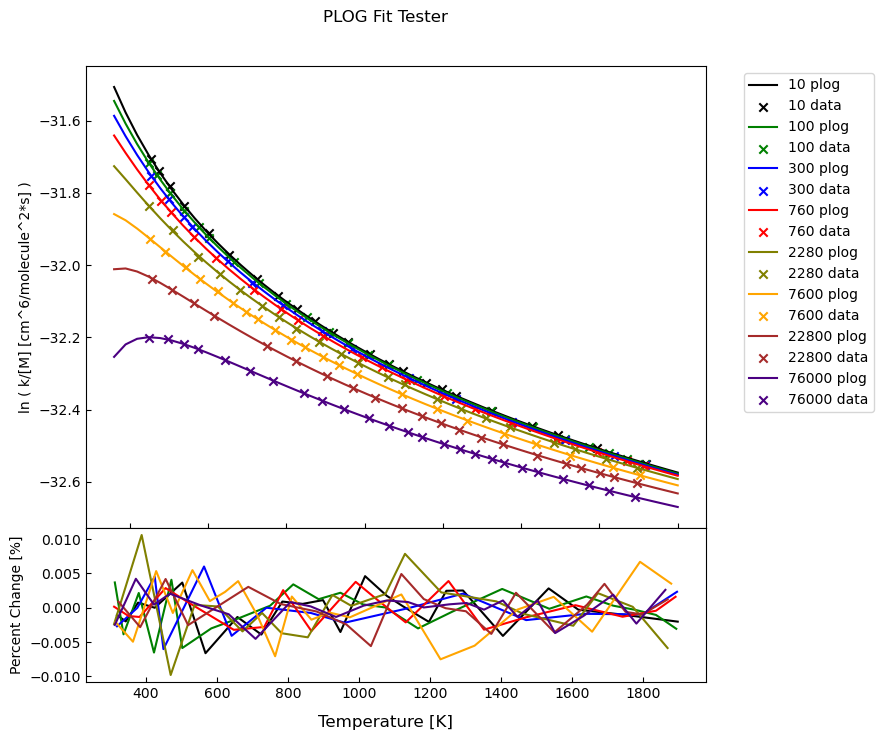

In [68]:
#STEP 2: LOAD THE PARAMETERS INTO "sandbox.yaml"

#STEP 3: CREATE A PLOT COMPARING THE ARRENHIUS FUNCTION OF THE FITTED PARAMETERS TO THE ORIGINAL GRAPH-READ DATA
fig = plt.figure(figsize=(8, 8))
spec = gridspec.GridSpec(ncols=1, nrows=2,hspace=0, height_ratios=[3, 1])
fig.suptitle(t='PLOG Fit Tester', x=0.5, y=0.95)
fig.supxlabel(t='Temperature [K]', x=0.5, y=0.05)
ax0 = fig.add_subplot(spec[0])
ax1 = fig.add_subplot(spec[1])
ax0.set_ylabel('ln ( k/[M] [cm^6/molecule^2*s] )')
ax1.set_ylabel('Percent Change [%]')
p_list = [10,100,300,760,2280,7600,22800,76000]
T_list = np.linspace(200,2000,50)
reaction_plog = 'H + O2 <=> HO2'
for i, p in enumerate(p_list):
    ratelist_plog = []
    for j, T in enumerate(T_list):
        gas = ct.Solution('test/data/sandbox.yaml')
        # print(p)
        gas.TPX = T, p/760, 'H2:0.2,O2:0.2,Ar:0.8'
        rc_plog = gas.forward_rate_constants[gas.reaction_equations().index(reaction_plog)] # m3/kmol/s
        rc_plog = rc_plog*1000 # cm3/mol*s
        rc_plog_M_molec = np.divide(rc_plog, np.square(N_A)) # cm6/molec2*s
        ratelist_plog.append(np.log(rc_plog_M_molec))
    ax0.plot(T_list,ratelist_plog,label=str(p) + ' plog',linestyle='solid',color=pltcolours[i])
    dataset = pd.read_csv(fname) # data from klippy
    dataset_p = dataset[dataset['P(torr)']==p]
    T_data=dataset_p['T']
    k_data_og=dataset_p['lnK/M (cm6/molec^2/sec)']  # cm3/mol/s
    ax0.scatter(T_data,k_data_og,marker='x',color=pltcolours[i],label=str(p) + ' data')
    ax1.plot(T_data, np.multiply(np.divide(np.subtract(np.interp(T_data,T_list,ratelist_plog),k_data_og),k_data_og),100),label=str(p) + ' plog',linestyle='solid',color=pltcolours[i])
ax0.tick_params(direction='in')
ax1.tick_params(direction='in')
ax0.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()


C:\Users\pjsin\AppData\Local\Temp\ipykernel_9996\2122705696.py:11: RuntimeWarning: invalid value encountered in log
  return np.log(arrhenius_rate(T, A, beta, Ea)) - ln_rate_constants


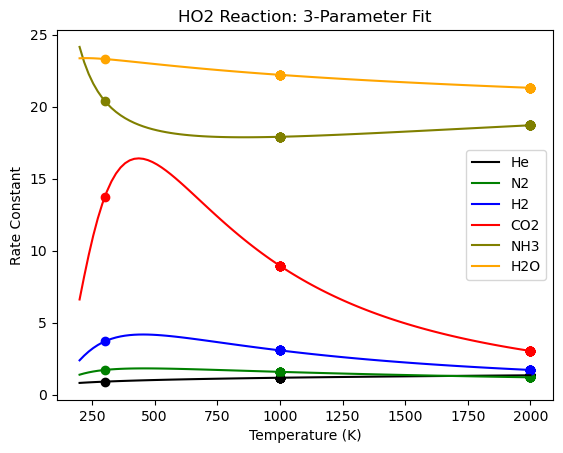

C:\Users\pjsin\AppData\Local\Temp\ipykernel_9996\2122705696.py:28: RuntimeWarning: invalid value encountered in log
  return np.log(arrhenius_rate(T, A, beta)) - ln_rate_constants


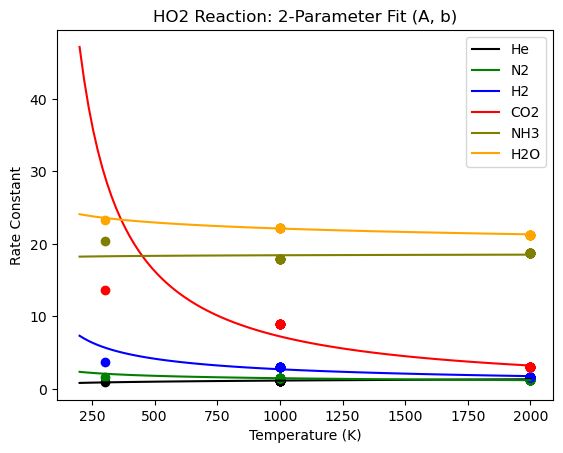

C:\Users\pjsin\AppData\Local\Temp\ipykernel_9996\2122705696.py:45: RuntimeWarning: invalid value encountered in log
  return np.log(arrhenius_rate(T, A, Ea)) - ln_rate_constants


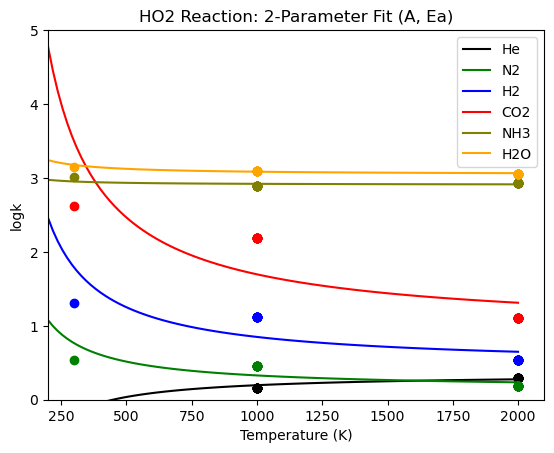

In [105]:

# STEP 4: PERFORM A LEAST-SQUARES FIT OF EFFICIENCIES AT THREE DIFFERENT TEMPERATURES FOR EACH COLLIDER BEYOND AR (USING JASPER PAPER).
# OBTAIN ARRHENIUS PARAMETERS THAT DESCRIBE THEIR EIG0 FUNCTION (RELATIVE TO EIG0 FOR AR)
from scipy.optimize import least_squares

def plot_ratefit(temperatures, rate_constants, pltcolour, labell): #3-parameter fit (A, b, Ea)
    def arrhenius_rate(T, A, beta, Ea):
        R = 8.314  # Gas constant in J/(mol K)
        return A * T**beta * np.exp(-Ea / (R * T))
    def fit_function(params, T, ln_rate_constants):
        A, beta, Ea = params
        return np.log(arrhenius_rate(T, A, beta, Ea)) - ln_rate_constants
    initial_guess = [1.0e6, 0.5, 50.0]  
    result = least_squares(fit_function, initial_guess, args=(temperatures, np.log(rate_constants)))
    A_fit, beta_fit, Ea_fit = result.x
    T_range = np.linspace(200, 2000, 100)
    fit_curve = np.exp(np.log(arrhenius_rate(T_range, A_fit, beta_fit, Ea_fit)))
    #print(('- collider: "%s"\n  low-P-rate-constant: {A: %.5e, b: %.5e, Ea: %.5e}')%(labell.upper(),A_fit, beta_fit, Ea_fit))
    plt.plot(T_range, fit_curve, label=labell, color=pltcolour)
    plt.scatter(temperatures, rate_constants, label=None, color=pltcolour)

def plot_ratefit_A_b(temperatures, rate_constants, pltcolour, labell): #2-parameter fit (A, b)
    def arrhenius_rate(T, A, beta):
        R = 8.314  # Gas constant in J/(mol K)
        Ea=0
        return A * T**beta * np.exp(-Ea / (R * T))
    def fit_function(params, T, ln_rate_constants):
        A, beta = params
        return np.log(arrhenius_rate(T, A, beta)) - ln_rate_constants
    initial_guess = [1.0e6, 0.5]  
    result = least_squares(fit_function, initial_guess, args=(temperatures, np.log(rate_constants)))
    A_fit, beta_fit = result.x
    T_range = np.linspace(200, 2000, 100)
    fit_curve = np.exp(np.log(arrhenius_rate(T_range, A_fit, beta_fit)))
    #print(('- collider: "%s"\n  low-P-rate-constant: {A: %.5e, b: %.5e, Ea: 0.0}')%(labell.upper(),A_fit, beta_fit))
    plt.plot(T_range, fit_curve, label=labell, color=pltcolour)
    plt.scatter(temperatures, rate_constants, label=None, color=pltcolour)

def plot_ratefit_A_Ea(temperatures, rate_constants, pltcolour, labell): #2-parameter fit (A, Ea)
    def arrhenius_rate(T, A, Ea):
        beta=0 #generally -4 to 4 range
        R = 8.314  # Gas constant in J/(mol K)
        return A * T**beta * np.exp(-Ea / (R * T))
    def fit_function(params, T, ln_rate_constants):
        A, Ea = params
        return np.log(arrhenius_rate(T, A, Ea)) - ln_rate_constants
    initial_guess = [1.0e6, 50.0]  
    result = least_squares(fit_function, initial_guess, args=(temperatures, np.log(rate_constants)))
    A_fit, Ea_fit = result.x
    T_range = np.linspace(200, 2000, 100)
    logk_fit = np.log(arrhenius_rate(T_range, A_fit, Ea_fit))
    #print(('- collider: "%s"\n  low-P-rate-constant: {A: %.5e, b: 0, Ea: %.5e}')%(labell.upper(),A_fit, Ea_fit))
    plt.plot(T_range, logk_fit, label=labell, color=pltcolour)
    plt.scatter(temperatures, np.log(rate_constants), label=None, color=pltcolour)

pltcolours = ['k', 'g', 'b', 'r', 'olive', 'orange', 'brown', 'indigo']
a,b,c=1,10,20 #weights of each data point
plt.figure()
plot_ratefit(np.array([300]*a + [1000]*b + [2000]*c), np.array([0.90]*a + [1.17]*b + [1.34]*c), pltcolours[0], "He")
plot_ratefit(np.array([300]*a + [1000]*b + [2000]*c), np.array([1.71]*a+ [1.58]*b + [1.20]*c), pltcolours[1], "N2")
plot_ratefit(np.array([300]*a + [1000]*b + [2000]*c), np.array([3.69]*a+ [3.07]*b + [1.71]*c), pltcolours[2], "H2")
plot_ratefit(np.array([300]*a + [1000]*b + [2000]*c), np.array([13.7]*a+ [8.94]*b + [3.03]*c), pltcolours[3], "CO2")
plot_ratefit(np.array([300]*a + [1000]*b + [2000]*c), np.array([20.4]*a+ [17.9]*b + [18.7]*c), pltcolours[4], "NH3")
plot_ratefit(np.array([300]*a + [1000]*b + [2000]*c), np.array([23.3]*a+ [22.2]*b + [21.3]*c), pltcolours[5], "H2O")
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("HO2 Reaction: 3-Parameter Fit")
plt.show()

plt.figure()
plot_ratefit_A_b(np.array([300]*a + [1000]*b + [2000]*c), np.array([0.90]*a + [1.17]*b + [1.34]*c), pltcolours[0], "He")
plot_ratefit_A_b(np.array([300]*a + [1000]*b + [2000]*c), np.array([1.71]*a+ [1.58]*b + [1.20]*c), pltcolours[1], "N2")
plot_ratefit_A_b(np.array([300]*a + [1000]*b + [2000]*c), np.array([3.69]*a+ [3.07]*b + [1.71]*c), pltcolours[2], "H2")
plot_ratefit_A_b(np.array([300]*a + [1000]*b + [2000]*c), np.array([13.7]*a+ [8.94]*b + [3.03]*c), pltcolours[3], "CO2")
plot_ratefit_A_b(np.array([300]*a + [1000]*b + [2000]*c), np.array([20.4]*a+ [17.9]*b + [18.7]*c), pltcolours[4], "NH3")
plot_ratefit_A_b(np.array([300]*a + [1000]*b + [2000]*c), np.array([23.3]*a+ [22.2]*b + [21.3]*c), pltcolours[5], "H2O")
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("HO2 Reaction: 2-Parameter Fit (A, b)")
plt.show()

plt.figure()
plot_ratefit_A_Ea(np.array([300]*a + [1000]*b + [2000]*c), np.array([0.90]*a + [1.17]*b + [1.34]*c), pltcolours[0], "He")
plot_ratefit_A_Ea(np.array([300]*a + [1000]*b + [2000]*c), np.array([1.71]*a+ [1.58]*b + [1.20]*c), pltcolours[1], "N2")
plot_ratefit_A_Ea(np.array([300]*a + [1000]*b + [2000]*c), np.array([3.69]*a+ [3.07]*b + [1.71]*c), pltcolours[2], "H2")
plot_ratefit_A_Ea(np.array([300]*a + [1000]*b + [2000]*c), np.array([13.7]*a+ [8.94]*b + [3.03]*c), pltcolours[3], "CO2")
plot_ratefit_A_Ea(np.array([300]*a + [1000]*b + [2000]*c), np.array([20.4]*a+ [17.9]*b + [18.7]*c), pltcolours[4], "NH3")
plot_ratefit_A_Ea(np.array([300]*a + [1000]*b + [2000]*c), np.array([23.3]*a+ [22.2]*b + [21.3]*c), pltcolours[5], "H2O")
plt.xlabel('Temperature (K)')
plt.ylabel('logk')
plt.xlim([200,2100])
plt.ylim([0,5])
plt.legend()
plt.title("HO2 Reaction: 2-Parameter Fit (A, Ea)")
plt.show()

#STEP 5: PASTE THE PRINTED OUTPUT INTO "alzuetamechanism_LMRR.yaml"

#### 1.3) Reaction 69: NH3 (+M) <=> NH2 + H (+M)
* Copied PLOG data for Ar collider from Table 1 of ["An experimental, theoretical and kinetic-modeling study of the gas-phase oxidation of ammonia"](https://drive.google.com/file/d/15JVwsEIgb1P6gJmXaWZOH6yQ5QkdQvjg/view?usp=sharing)

Final table created from calculations:

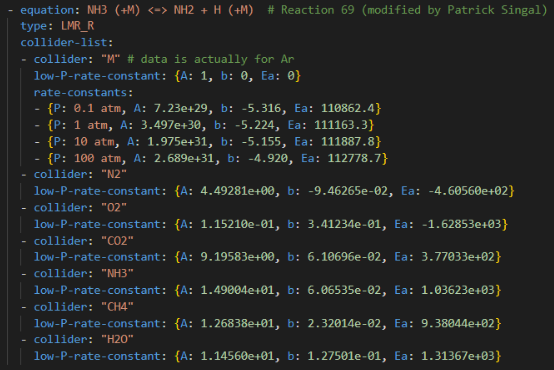

C:\Users\pjsin\AppData\Local\Temp\ipykernel_9996\3080860135.py:45: RuntimeWarning: invalid value encountered in log
  return np.log(arrhenius_rate(T, A, beta, Ea)) - ln_rate_constants


- collider: "N2"
  low-P-rate-constant: {A: 4.49281e+00, b: -9.46265e-02, Ea: -4.60560e+02}
- collider: "O2"
  low-P-rate-constant: {A: 1.15210e-01, b: 3.41234e-01, Ea: -1.62853e+03}
- collider: "CO2"
  low-P-rate-constant: {A: 9.19583e+00, b: 6.10696e-02, Ea: 3.77033e+02}
- collider: "NH3"
  low-P-rate-constant: {A: 1.49004e+01, b: 6.06535e-02, Ea: 1.03623e+03}
- collider: "CH4"
  low-P-rate-constant: {A: 1.26838e+01, b: 2.32014e-02, Ea: 9.38044e+02}
- collider: "H2O"
  low-P-rate-constant: {A: 1.14560e+01, b: 1.27501e-01, Ea: 1.31367e+03}


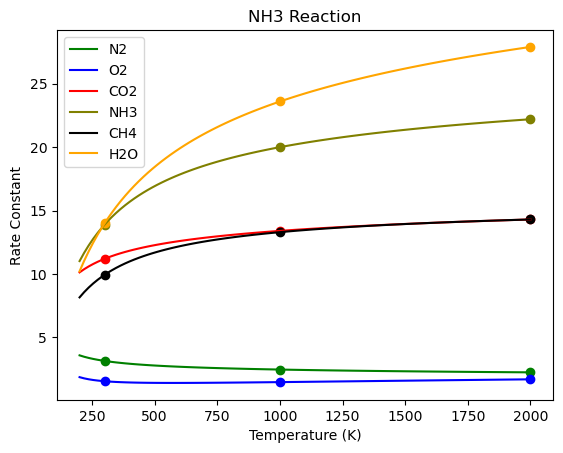

In [28]:
# STEP 1: PERFORM A LEAST-SQUARES FIT OF EFFICIENCIES AT THREE DIFFERENT TEMPERATURES FOR EACH COLLIDER BEYOND AR (USING JASPER PAPER).
# OBTAIN ARRHENIUS PARAMETERS THAT DESCRIBE THEIR EIG0 FUNCTION (RELATIVE TO EIG0 FOR AR)

args_N2 = (np.array([300, 1000, 2000]), np.array([3.15,2.47,2.25]), pltcolours[1], "N2")
args_O2 = (np.array([300, 1000, 2000]), np.array([1.55,1.48,1.70]), pltcolours[2], "O2")
args_CO2 = (np.array([300, 1000, 2000]), np.array([11.2,13.4,14.3]), pltcolours[3], "CO2")
args_NH3 = (np.array([300, 1000, 2000]), np.array([13.9,20.0,22.2]), pltcolours[4], "NH3")
args_CH4 = (np.array([300, 1000, 2000]), np.array([9.94,13.3,14.3]), pltcolours[0], "CH4")
args_H2O = (np.array([300, 1000, 2000]), np.array([14.0,23.6,27.9]), pltcolours[5], "H2O") 

plt.figure() #using Jasper efficiencies
plot_ratefit(args_N2)
plot_ratefit(args_O2)
plot_ratefit(args_CO2)
plot_ratefit(args_NH3)
plot_ratefit(args_CH4)
plot_ratefit(args_H2O)
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("NH3 Reaction")
plt.show()

plt.figure()
plot_ratefit_A_b(args_N2)
plot_ratefit_A_b(args_O2)
plot_ratefit_A_b(args_CO2)
plot_ratefit_A_b(args_NH3)
plot_ratefit_A_b(args_CH4)
plot_ratefit_A_b(args_H2O)
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("HO2 Reaction: 2-Parameter Fit (A, b)")
plt.show()

plt.figure()
plot_ratefit_A_Ea(args_N2)
plot_ratefit_A_Ea(args_O2)
plot_ratefit_A_Ea(args_CO2)
plot_ratefit_A_Ea(args_NH3)
plot_ratefit_A_Ea(args_CH4)
plot_ratefit_A_Ea(args_H2O)
plot_ratefit_A_Ea(np.array([300, 1000, 2000]), np.array([0.90, 1.17, 1.34]), pltcolours[0], "He")
plot_ratefit_A_Ea(np.array([300, 1000, 2000]), np.array([1.71, 1.58, 1.20]), pltcolours[1], "N2")
plot_ratefit_A_Ea(np.array([300, 1000, 2000]), np.array([3.69, 3.07, 1.71]), pltcolours[2], "H2")
plot_ratefit_A_Ea(np.array([300, 1000, 2000]), np.array([13.7, 8.94, 3.03]), pltcolours[3], "CO2")
plot_ratefit_A_Ea(np.array([300, 1000, 2000]), np.array([20.4, 17.9, 18.7]), pltcolours[4], "NH3")
plot_ratefit_A_Ea(np.array([300, 1000, 2000]), np.array([23.3, 22.2, 21.3]), pltcolours[5], "H2O") 
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("HO2 Reaction: 2-Parameter Fit (A, Ea)")
plt.show()

#STEP 2: PASTE THE PRINTED OUTPUT INTO "alzuetamechanism_LMRR.yaml"

#### 1.4) Reaction 164: HNO (+M) <=> NO + H (+M)
* Copied PLOG data for Ar collider from Table 1 of ["An experimental, theoretical and kinetic-modeling study of the gas-phase oxidation of ammonia"](https://drive.google.com/file/d/15JVwsEIgb1P6gJmXaWZOH6yQ5QkdQvjg/view?usp=sharing)

Final table produced from calculations:

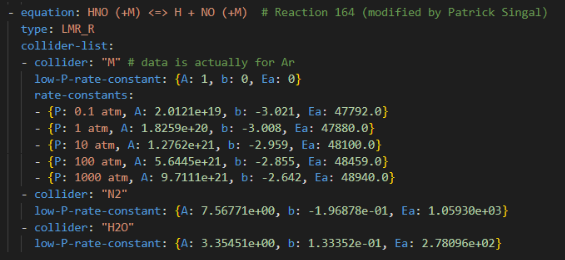

C:\Users\pjsin\AppData\Local\Temp\ipykernel_9996\3080860135.py:45: RuntimeWarning: invalid value encountered in log
  return np.log(arrhenius_rate(T, A, beta, Ea)) - ln_rate_constants


- collider: "N2"
  low-P-rate-constant: {A: 7.56771e+00, b: -1.96878e-01, Ea: 1.05930e+03}
- collider: "H2O"
  low-P-rate-constant: {A: 3.35451e+00, b: 1.33352e-01, Ea: 2.78096e+02}


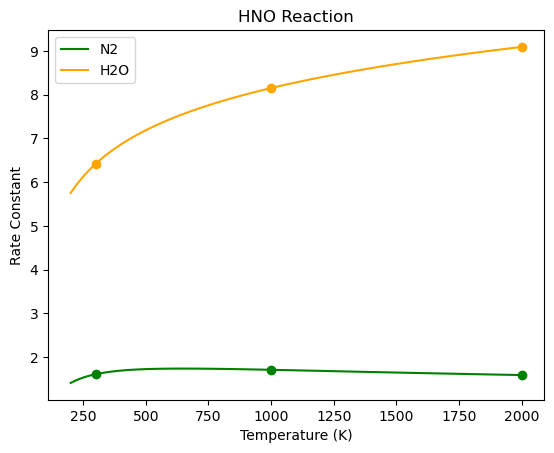

In [29]:
# STEP 1: PERFORM A LEAST-SQUARES FIT OF EFFICIENCIES AT THREE DIFFERENT TEMPERATURES FOR EACH COLLIDER BEYOND AR (USING JASPER PAPER).
# OBTAIN ARRHENIUS PARAMETERS THAT DESCRIBE THEIR EIG0 FUNCTION (RELATIVE TO EIG0 FOR AR)

args_N2=(np.array([300, 1000, 2000]), np.array([1.61,1.71,1.59]), pltcolours[1], "N2")
args_H2O=(np.array([300, 1000, 2000]), np.array([6.42,8.15,9.09]), pltcolours[5], "H2O") 

plt.figure() #using Jasper efficiencies
plot_ratefit(args_N2)
plot_ratefit(args_H2O)
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("HNO Reaction")
plt.show()

plt.figure()
plot_ratefit_A_b(args_N2)
plot_ratefit_A_b(args_H2O)
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("HNO Reaction: 2-Parameter Fit (A, b)")
plt.show()

plt.figure()
plot_ratefit_A_Ea(args_N2)
plot_ratefit_A_Ea(args_H2O)
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("HNO Reaction: 2-Parameter Fit (A, Ea)")
plt.show()

#STEP 2: PASTE THE PRINTED OUTPUT INTO "alzuetamechanism_LMRR.yaml"

#### 1.5) Reaction 87: NH2 + NH2 (+M) <=> N2H4 (+M)

Original Troe table, using data from Klippenstein:

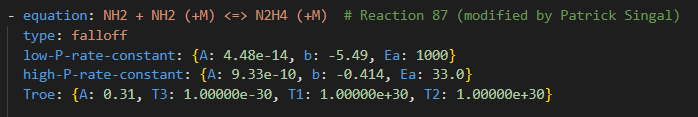


Final table produced from calculations:

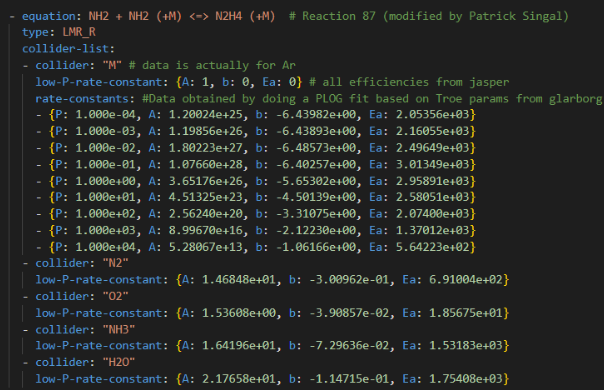

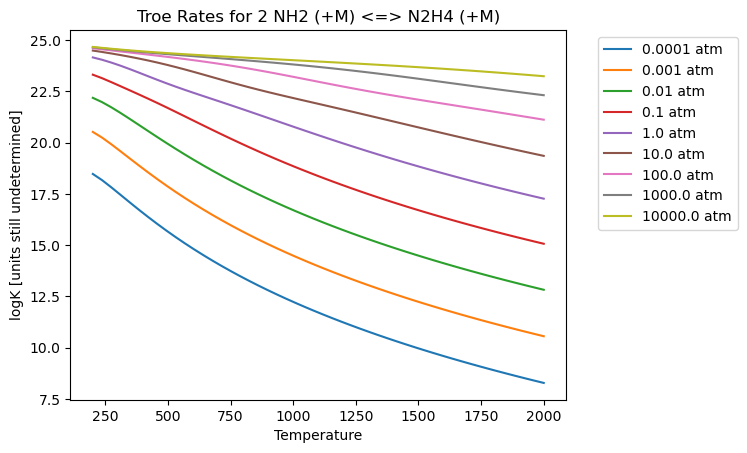

- {P: 1.000e-04, A: 1.20024e+25, b: -6.43982e+00, Ea: 2.05356e+03}
- {P: 1.000e-03, A: 1.19856e+26, b: -6.43893e+00, Ea: 2.16055e+03}
- {P: 1.000e-02, A: 1.80223e+27, b: -6.48573e+00, Ea: 2.49649e+03}
- {P: 1.000e-01, A: 1.07660e+28, b: -6.40257e+00, Ea: 3.01349e+03}
- {P: 1.000e+00, A: 3.65176e+26, b: -5.65302e+00, Ea: 2.95891e+03}
- {P: 1.000e+01, A: 4.51325e+23, b: -4.50139e+00, Ea: 2.58051e+03}
- {P: 1.000e+02, A: 2.56240e+20, b: -3.31075e+00, Ea: 2.07400e+03}
- {P: 1.000e+03, A: 8.99670e+16, b: -2.12230e+00, Ea: 1.37012e+03}
- {P: 1.000e+04, A: 5.28067e+13, b: -1.06166e+00, Ea: 5.64223e+02}


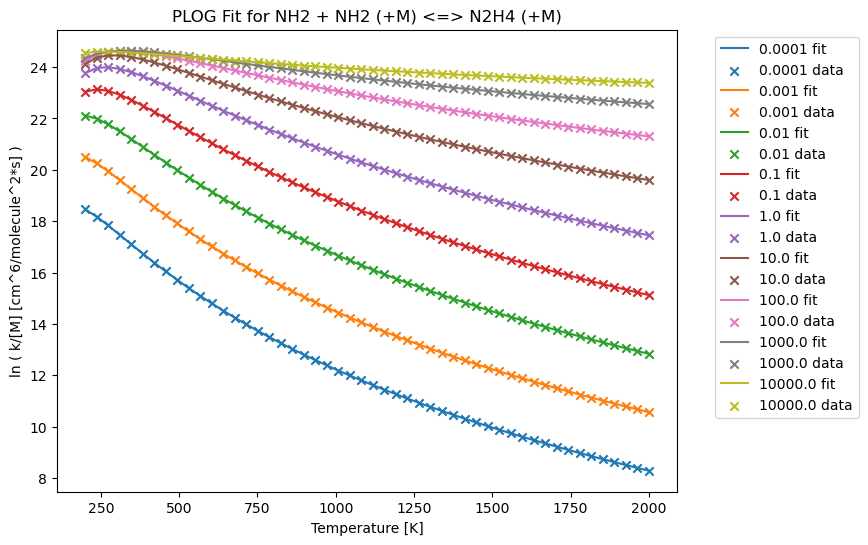

- collider: "N2"
  low-P-rate-constant: {A: 1.46848e+01, b: -3.00962e-01, Ea: 6.91004e+02}
- collider: "O2"
  low-P-rate-constant: {A: 1.53608e+00, b: -3.90857e-02, Ea: 1.85675e+01}
- collider: "NH3"
  low-P-rate-constant: {A: 1.64196e+01, b: -7.29636e-02, Ea: 1.53183e+03}
- collider: "H2O"
  low-P-rate-constant: {A: 2.17658e+01, b: -1.14715e-01, Ea: 1.75408e+03}


C:\Users\pjsin\AppData\Local\Temp\ipykernel_9996\3080860135.py:45: RuntimeWarning: invalid value encountered in log
  return np.log(arrhenius_rate(T, A, beta, Ea)) - ln_rate_constants


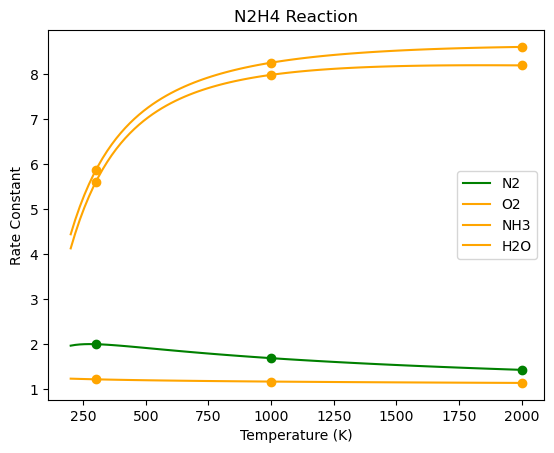

In [33]:
#STEP 1: GET RATE CONSTANTS FROM TROE PARAMETERS
def getKfromTroe(P_list,T_list,rxn,ref_collider):
    file = 'test/data/sandbox.yaml'
    reaction = rxn
    gas = ct.Solution(file)
    def getK(Temp,Pres,X) :
        gas.TPX = Temp,Pres,X
        k = gas.forward_rate_constants[gas.reaction_equations().index(reaction)]
        return k
    plt.figure()
    k_P=[]
    for P in P_list:
        k_T = []
        for T in T_list:
            k_T.append(getK(T,P,{ref_collider:1}))
        k_P.append(k_T)
        plt.plot(T_list,np.log(k_T),label=str(P/101325)+" atm")
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.title("Troe Rates for "+rxn)
    plt.xlabel("Temperature")
    plt.ylabel("logK [units still undetermined]")
    plt.show()
    return k_P
P_list=[0.0001*101325,0.001*101325,0.01*101325,0.1*101325,1*101325,10*101325,100*101325,1000*101325,10000*101325]
T_list=np.linspace(200,2000,50)
k_P_5 = getKfromTroe(P_list,T_list,'2 NH2 (+M) <=> N2H4 (+M)', 'AR')

#STEP 2: PERFORM A PLOG FIT FOR AR COLLIDER
def plogFit(P_list,T_list,k_P,rxn):
    def arrhenius(T, A, n, Ea):
        return np.log(A) + n*np.log(T)+ (-Ea/(1.987*T))
    plt.figure(figsize=(8,6))
    dataset = pd.read_csv(fname)
    for i,p in enumerate(P_list):
        k_data = k_P[i] #rate constants across a temperature range, for a given P
        popt, pcov = curve_fit(arrhenius, T_list, np.log(k_data),maxfev = 2000)
        print(("- {P: %.3e, A: %.5e, b: %.5e, Ea: %.5e}")%(p/101325, popt[0],popt[1],popt[2]))
        lnk_fit = arrhenius(T_list,popt[0],popt[1],popt[2])
        plt.plot(T_list,lnk_fit,label=str(p/101325) + ' fit',linestyle='solid')
        plt.scatter(T_list,lnk_fit,marker='x',label=str(p/101325) + ' data')
    plt.title('PLOG Fit for '+rxn)
    plt.xlabel('Temperature [K]')
    plt.ylabel('ln ( k/[M] [cm^6/molecule^2*s] )')
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.show()
plogFit(P_list,T_list,k_P_5,'NH2 + NH2 (+M) <=> N2H4 (+M)')

# STEP 3: PERFORM A LEAST-SQUARES FIT OF EFFICIENCIES AT THREE DIFFERENT TEMPERATURES FOR EACH COLLIDER BEYOND AR (USING JASPER PAPER).
# OBTAIN ARRHENIUS PARAMETERS THAT DESCRIBE THEIR EIG0 FUNCTION (RELATIVE TO EIG0 FOR AR)
args_N2 = (np.array([300,1000,2000]), np.array([2.00,1.69,1.43]), pltcolours[1], "N2")
args_O2 = (np.array([300,1000,2000]), np.array([1.22,1.17,1.14]), pltcolours[5], "O2")
args_NH3 = (np.array([300,1000,2000]), np.array([5.86,8.25,8.60]), pltcolours[5], "NH3")
args_H2O = (np.array([300,1000,2000]), np.array([5.60,7.98,8.19]), pltcolours[5], "H2O") 

plt.figure() #using Jasper efficiencies
plot_ratefit(args_N2)
plot_ratefit(args_O2)
plot_ratefit(args_NH3)
plot_ratefit(args_H2O)
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("N2H4 Reaction")
plt.show()

plt.figure()
plot_ratefit_A_b(args_N2)
plot_ratefit_A_b(args_O2)
plot_ratefit_A_b(args_NH3)
plot_ratefit_A_b(args_H2O)
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("N2H4 Reaction: 2-Parameter Fit (A, b)")
plt.show()

plt.figure()
plot_ratefit_A_Ea(args_N2)
plot_ratefit_A_Ea(args_O2)
plot_ratefit_A_Ea(args_CO2)
plot_ratefit_A_Ea(args_NH3)
plot_ratefit_A_Ea(args_CH4)
plot_ratefit_A_Ea(args_H2O)
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("N2H4 Reaction: 2-Parameter Fit (A, Ea)")
plt.show()

#STEP 4: PASTE THE PRINTED OUTPUT INTO "alzuetamechanism_LMRR.yaml"

#### 1.6) Reaction 11: H2O (+M) <=> H + OH (+M)

original form (three-body)

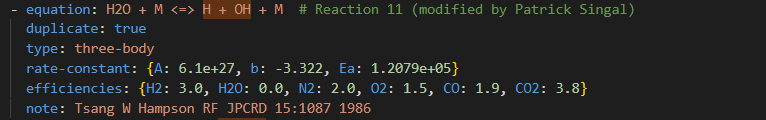

troe form

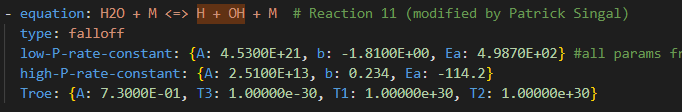

Final table produced from calculations

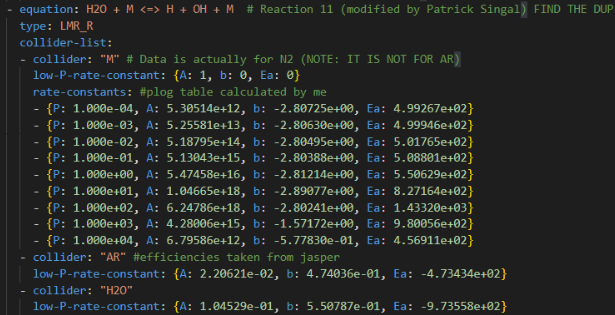

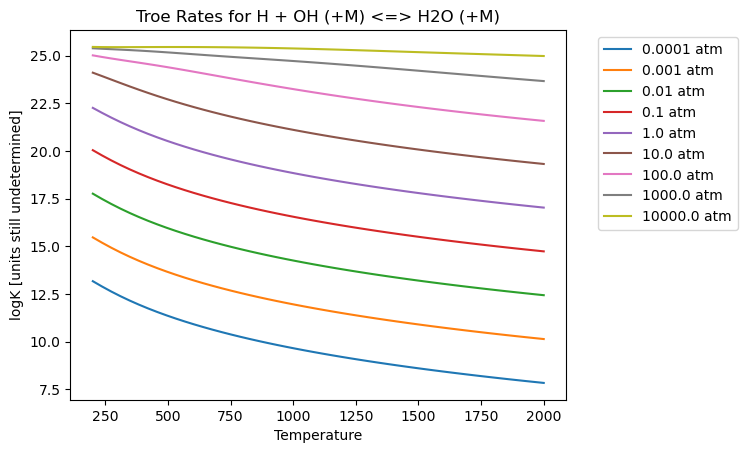

- {P: 1.000e-04, A: 5.30514e+12, b: -2.80725e+00, Ea: 4.99267e+02}
- {P: 1.000e-03, A: 5.25581e+13, b: -2.80630e+00, Ea: 4.99946e+02}
- {P: 1.000e-02, A: 5.18795e+14, b: -2.80495e+00, Ea: 5.01765e+02}
- {P: 1.000e-01, A: 5.13043e+15, b: -2.80388e+00, Ea: 5.08801e+02}
- {P: 1.000e+00, A: 5.47458e+16, b: -2.81214e+00, Ea: 5.50629e+02}
- {P: 1.000e+01, A: 1.04665e+18, b: -2.89077e+00, Ea: 8.27164e+02}
- {P: 1.000e+02, A: 6.24786e+18, b: -2.80241e+00, Ea: 1.43320e+03}
- {P: 1.000e+03, A: 4.28006e+15, b: -1.57172e+00, Ea: 9.80056e+02}
- {P: 1.000e+04, A: 6.79586e+12, b: -5.77830e-01, Ea: 4.56911e+02}


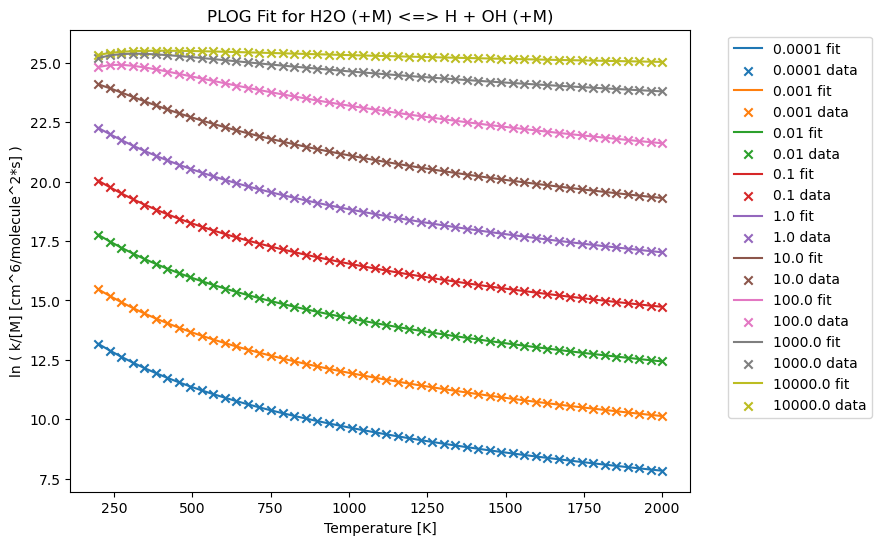

C:\Users\pjsin\AppData\Local\Temp\ipykernel_9996\3080860135.py:45: RuntimeWarning: invalid value encountered in log
  return np.log(arrhenius_rate(T, A, beta, Ea)) - ln_rate_constants


- collider: "AR"
  low-P-rate-constant: {A: 2.20621e-02, b: 4.74036e-01, Ea: -4.73434e+02}
- collider: "H2O"
  low-P-rate-constant: {A: 1.04529e-01, b: 5.50787e-01, Ea: -9.73558e+02}


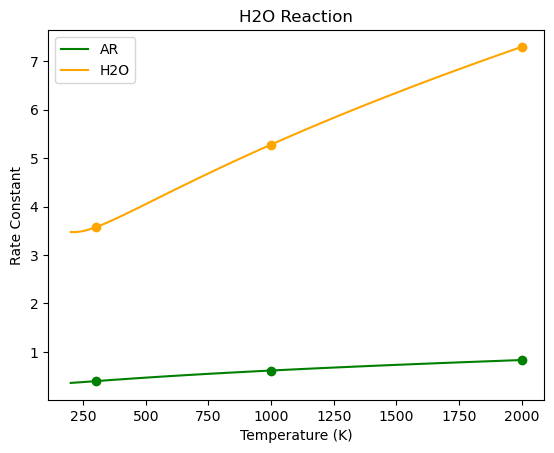

In [34]:
#STEP 1: GET RATE CONSTANTS FROM TROE PARAMETERS
P_list=[0.0001*101325,0.001*101325,0.01*101325,0.1*101325,1*101325,10*101325,100*101325,1000*101325,10000*101325]
T_list=np.linspace(200,2000,50)
k_P_6 = getKfromTroe(P_list,T_list,'H + OH (+M) <=> H2O (+M)','N2')

#STEP 2: PERFORM A PLOG FIT FOR N2 COLLIDER
plogFit(P_list,T_list,k_P_6,'H2O (+M) <=> H + OH (+M)')

# STEP 3: PERFORM A LEAST-SQUARES FIT OF EFFICIENCIES AT THREE DIFFERENT TEMPERATURES FOR EACH COLLIDER BEYOND AR (USING JASPER PAPER).
# OBTAIN ARRHENIUS PARAMETERS THAT DESCRIBE THEIR EIG0 FUNCTION (RELATIVE TO EIG0 FOR N2)
plt.figure()
plot_ratefit(np.array([300,1000,2000]), np.array([1/2.51,1/1.62,1/1.20]), pltcolours[1], "AR")
plot_ratefit(np.array([300,1000,2000]), np.array([8.97/2.51,8.55/1.62,8.75/1.20]), pltcolours[5], "H2O") 
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("H2O Reaction")
plt.show()


args_AR = (np.array([300,1000,2000]), np.array([1/2.51,1/1.62,1/1.20]), pltcolours[1], "AR")
args_H2O = (np.array([300,1000,2000]), np.array([8.97/2.51,8.55/1.62,8.75/1.20]), pltcolours[5], "H2O") 

plt.figure() #using Jasper efficiencies
plot_ratefit(args_AR)
plot_ratefit(args_O2)
plot_ratefit(args_CO2)
plot_ratefit(args_NH3)
plot_ratefit(args_CH4)
plot_ratefit(args_H2O)
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("NH3 Reaction")
plt.show()

plt.figure()
plot_ratefit_A_b(args_N2)
plot_ratefit_A_b(args_O2)
plot_ratefit_A_b(args_CO2)
plot_ratefit_A_b(args_NH3)
plot_ratefit_A_b(args_CH4)
plot_ratefit_A_b(args_H2O)
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("NH3 Reaction: 2-Parameter Fit (A, b)")
plt.show()

plt.figure()
plot_ratefit_A_Ea(args_N2)
plot_ratefit_A_Ea(args_O2)
plot_ratefit_A_Ea(args_CO2)
plot_ratefit_A_Ea(args_NH3)
plot_ratefit_A_Ea(args_CH4)
plot_ratefit_A_Ea(args_H2O)
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("NH3 Reaction: 2-Parameter Fit (A, Ea)")
plt.show()


#STEP 4: PASTE THE PRINTED OUTPUT INTO "alzuetamechanism_LMRR.yaml"

#### 1.7) H2O2 (+M) <=> OH + OH (+M)

original troe form, provided by alzueta et al

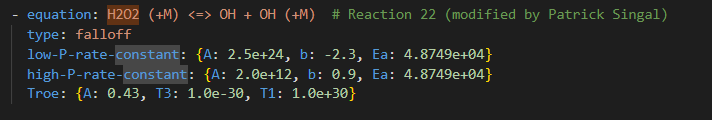

Final table produced from calculations

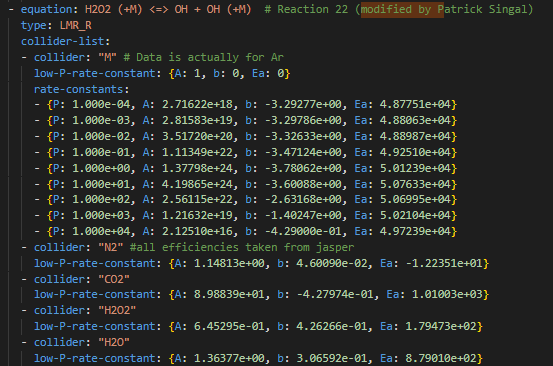

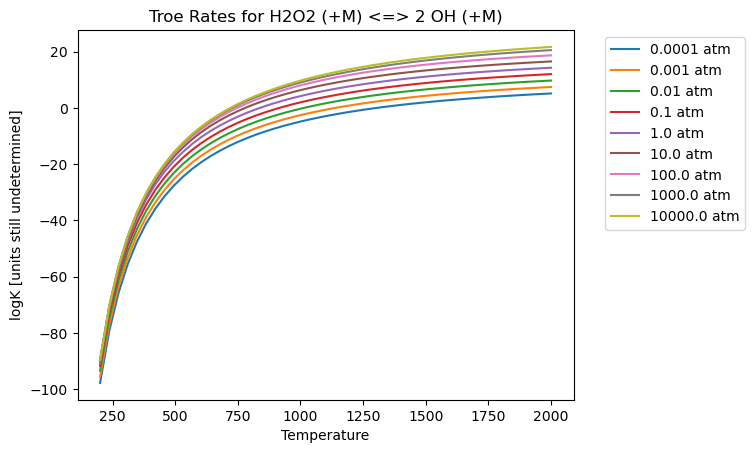

C:\Users\pjsin\AppData\Local\Temp\ipykernel_9996\144695280.py:31: RuntimeWarning: invalid value encountered in log
  return np.log(A) + n*np.log(T)+ (-Ea/(1.987*T))


- {P: 1.000e-04, A: 2.71622e+18, b: -3.29277e+00, Ea: 4.87751e+04}
- {P: 1.000e-03, A: 2.81583e+19, b: -3.29786e+00, Ea: 4.88063e+04}
- {P: 1.000e-02, A: 3.51720e+20, b: -3.32633e+00, Ea: 4.88987e+04}
- {P: 1.000e-01, A: 1.11349e+22, b: -3.47124e+00, Ea: 4.92510e+04}
- {P: 1.000e+00, A: 1.37798e+24, b: -3.78062e+00, Ea: 5.01239e+04}
- {P: 1.000e+01, A: 4.19865e+24, b: -3.60088e+00, Ea: 5.07633e+04}
- {P: 1.000e+02, A: 2.56115e+22, b: -2.63168e+00, Ea: 5.06995e+04}
- {P: 1.000e+03, A: 1.21632e+19, b: -1.40247e+00, Ea: 5.02104e+04}
- {P: 1.000e+04, A: 2.12510e+16, b: -4.29000e-01, Ea: 4.97239e+04}


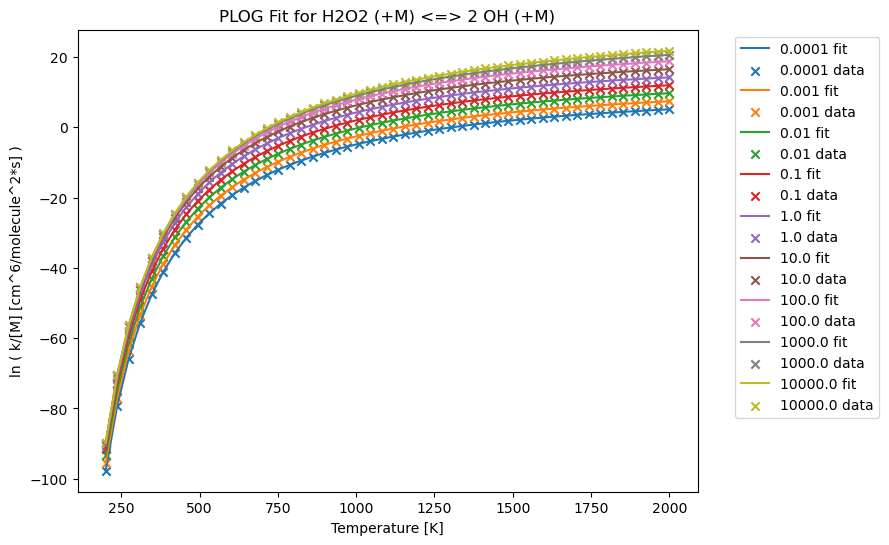

C:\Users\pjsin\AppData\Local\Temp\ipykernel_9996\3080860135.py:45: RuntimeWarning: invalid value encountered in log
  return np.log(arrhenius_rate(T, A, beta, Ea)) - ln_rate_constants


- collider: "N2"
  low-P-rate-constant: {A: 1.14813e+00, b: 4.60090e-02, Ea: -1.22351e+01}
- collider: "CO2"
  low-P-rate-constant: {A: 8.98839e+01, b: -4.27974e-01, Ea: 1.01003e+03}
- collider: "H2O2"
  low-P-rate-constant: {A: 6.45295e-01, b: 4.26266e-01, Ea: 1.79473e+02}
- collider: "H2O"
  low-P-rate-constant: {A: 1.36377e+00, b: 3.06592e-01, Ea: 8.79010e+02}


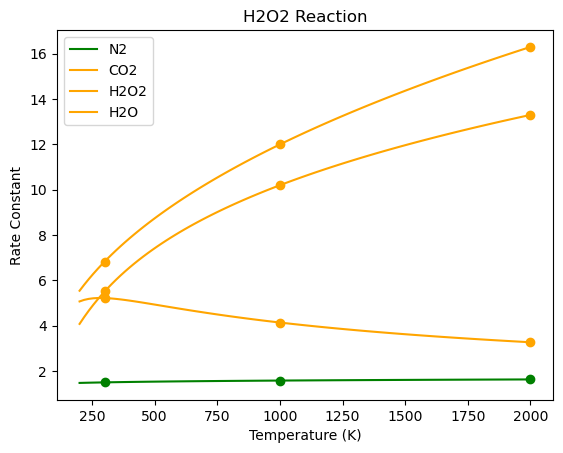

In [35]:
#STEP 1: GET RATE CONSTANTS FROM TROE PARAMETERS
P_list=[0.0001*101325,0.001*101325,0.01*101325,0.1*101325,1*101325,10*101325,100*101325,1000*101325,10000*101325]
T_list=np.linspace(200,2000,50)
k_P_7 = getKfromTroe(P_list,T_list,'H2O2 (+M) <=> 2 OH (+M)','AR')

#STEP 2: PERFORM A PLOG FIT FOR N2 COLLIDER
plogFit(P_list,T_list,k_P_7,'H2O2 (+M) <=> 2 OH (+M)')

# STEP 3: PERFORM A LEAST-SQUARES FIT OF EFFICIENCIES AT THREE DIFFERENT TEMPERATURES FOR EACH COLLIDER BEYOND AR (USING JASPER PAPER).
# OBTAIN ARRHENIUS PARAMETERS THAT DESCRIBE THEIR EIG0 FUNCTION (RELATIVE TO EIG0 FOR AR)
plt.figure()
plot_ratefit(np.array([300,1000,2000]), np.array([1.50,1.58,1.63]), pltcolours[1], "N2")
plot_ratefit(np.array([300,1000,2000]), np.array([5.22,4.14,3.27]), pltcolours[5], "CO2")
plot_ratefit(np.array([300,1000,2000]), np.array([6.83,12.0,16.3]), pltcolours[5], "H2O2") 
plot_ratefit(np.array([300,1000,2000]), np.array([5.51,10.2,13.3]), pltcolours[5], "H2O") 
plt.xlabel('Temperature (K)')
plt.ylabel('Rate Constant')
plt.legend()
plt.title("H2O2 Reaction")
plt.show()

#STEP 4: PASTE THE PRINTED OUTPUT INTO "alzuetamechanism_LMRR.yaml"

### 2) SPECIES PROFILE: MOLE FRACTION VS TIME
* Figure 5: ["Shock tube/laser absorption measurement of the rate constant of the reaction: H2O2 + CO2 2OH + CO2" (Shao et al.)](https://drive.google.com/file/d/1sFTKvGt-wBRdPPPJMrivpzrz7SSJv9Ee/view?usp=sharing)

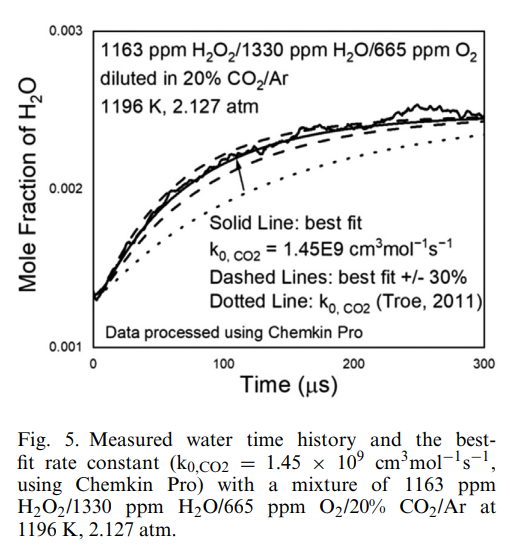

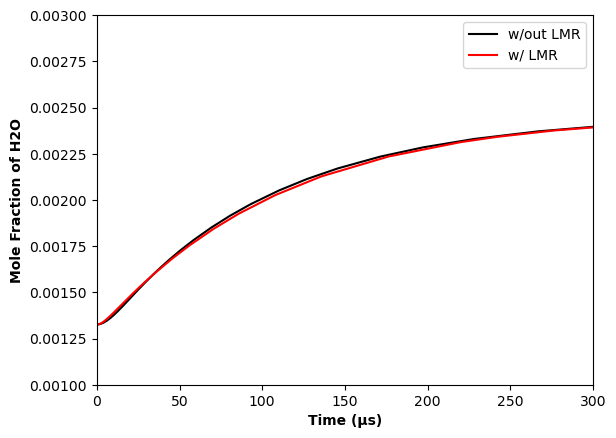

In [114]:
#REPRODUCING FIG 5
refSpecies='H2O'
X_H2O2 = 1163e-6
X_H2O = 1330e-6
X_O2 = 665e-6
X_CO2= 0.2*(1-X_H2O2-X_H2O-X_O2)
X_Ar = 1-X_CO2
def plotXvsTime(fname,pltlabel,pltcolour):
    # gas = ct.Solution('test/data/Burke_H2_ArBath.yaml')
    gas = ct.Solution(fname)
    gas.TPX = 1196, 2.127*101325, {'H2O2':X_H2O2, 'H2O':X_H2O, 'O2':X_O2, 'CO2':X_CO2, 'AR':X_Ar}
    r = ct.Reactor(contents=gas,energy="on")
    reactorNetwork = ct.ReactorNet([r]) # this will be the only reactor in the network
    timeHistory = ct.SolutionArray(gas, extra=['t'])
    estIgnitDelay = 1
    t = 0
    counter = 1
    while t < estIgnitDelay:
        t = reactorNetwork.step()
        if counter % 10 == 0:
            timeHistory.append(r.thermo.state, t=t)
        counter += 1
    tConv = 1e6 #time conversion factor (1e6 converts to microseconds)
    timeShift=0 # [seconds]
    shiftedTime = tConv*(timeHistory.t - timeShift)
    moleFrac = timeHistory(refSpecies).X 
    plt.plot(shiftedTime, moleFrac, color=pltcolour,label=pltlabel)
plt.figure()
plotXvsTime("test/data/alzuetamechanism.yaml","w/out LMR","k")
plotXvsTime("test/data/alzuetamechanism_LMRR.yaml","w/ LMR","r")
plt.xlim([0,300])
# plt.xlim([100,150])
plt.ylim([0.001,0.003])
# plt.ylim([0.002,0.0022])
plt.ylabel("Mole Fraction of H2O",**hfont)
plt.xlabel("Time (μs)", **hfont)
plt.legend()


### 3) SPECIES PROFILE: CONCENTRATION VS TEMPERATURE
#### 3.1) H2/O2/Ar/H2O mixture 
* Figure 1: ["Mutual inhibition effect of hydrogen and ammonia in oxidation processes and the role of ammonia as “strong” collider in third-molecular reactions" (Sabia et al.)](https://drive.google.com/file/d/1lvcGuuSI6QafO6S_lkemsA5UyTIxl1Lr/view?usp=sharing)

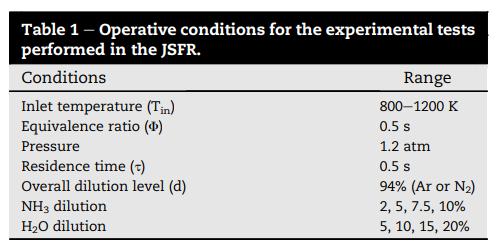
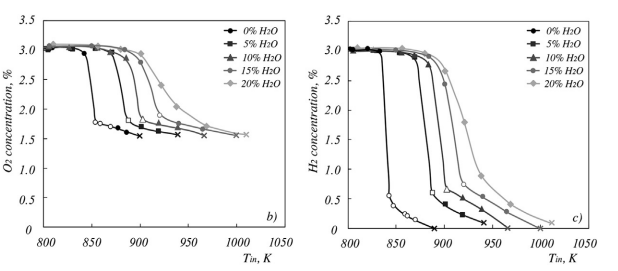

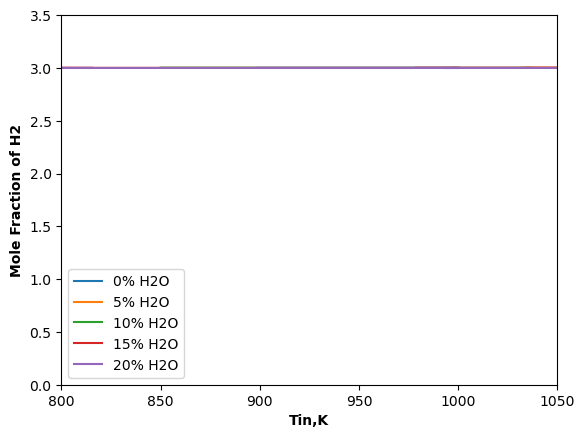

In [115]:
#REPRODUCING FIG 1
def plotXvsTemp(fname,pltlabel,pltcolour,fuel,oxidizer,diluent,refSpecies):
    gas = ct.Solution(fname)
    gas.TP = 1000, 1.2*101325
    gas.set_equivalence_ratio(0.5,fuel,oxidizer,diluent=diluent, fraction={"diluent":0.94},basis='mole')
    # Create a reactor
    reactor = ct.IdealGasReactor(gas)
    # Create a reactor network
    sim = ct.ReactorNet([reactor])
    # Time and data arrays for plotting
    times = []
    temperatures = []
    concentrations_H2 = []
    # Simulate the combustion reaction
    while sim.time < 50e-3:
        sim.step()
        times.append(sim.time)
        temperatures.append(reactor.T)
        concentrations_H2.append(gas[refSpecies].X[0]*100) #multiply by 100 to convert to a percentage
    plt.plot(temperatures,concentrations_H2,label=pltlabel)

plt.figure()
fname="test/data/alzuetamechanism_LMRR.yaml"
plotXvsTemp(fname,"0% H2O","k",fuel='H2:1',oxidizer='O2:1',diluent='AR:1.00,H2O:0.00',refSpecies='H2')
plotXvsTemp(fname,"5% H2O","k",fuel='H2:1',oxidizer='O2:1',diluent="AR:0.95,H2O:0.05",refSpecies='H2')
plotXvsTemp(fname,"10% H2O","k",fuel='H2:1',oxidizer='O2:1',diluent="AR:0.90,H2O:0.10",refSpecies='H2')
plotXvsTemp(fname,"15% H2O","k",fuel='H2:1',oxidizer='O2:1',diluent="AR:0.85,H2O:0.15",refSpecies='H2')
plotXvsTemp(fname,"20% H2O","k",fuel='H2:1',oxidizer='O2:1',diluent="AR:0.80,H2O:0.20",refSpecies='H2')
plt.xlim([800,1050])
plt.ylim([0,3.5])
plt.ylabel("Mole Fraction of H2",**hfont)
plt.xlabel("Tin,K", **hfont)
plt.legend()
plt.show()

#### 3.2) H2/O2/NH3/H2O mixture 
* Figure 2: ["Mutual inhibition effect of hydrogen and ammonia in oxidation processes and the role of ammonia as “strong” collider in third-molecular reactions" (Sabia et al.)](https://drive.google.com/file/d/1lvcGuuSI6QafO6S_lkemsA5UyTIxl1Lr/view?usp=sharing)

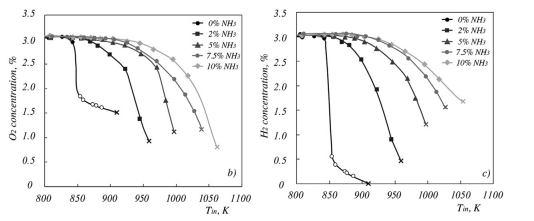

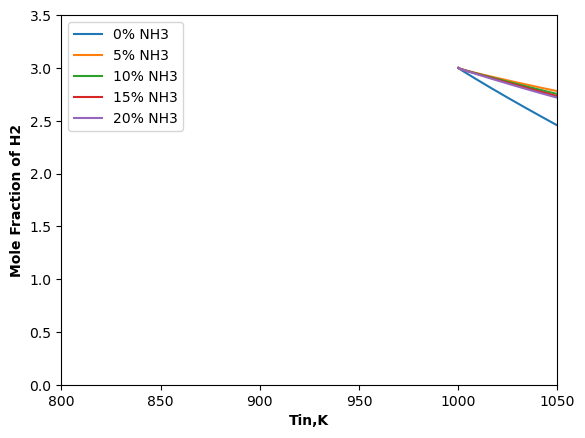

In [23]:
#REPRODUCING FIG 2
plt.figure()
fname="test/data/alzuetamechanism.yaml"
plotXvsTemp(fname,"0% NH3","k",fuel='H2:1',oxidizer='O2:1',diluent='Ar:1.00,NH3:0.00',refSpecies='H2')
plotXvsTemp(fname,"5% NH3","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.95,NH3:0.05",refSpecies='H2')
plotXvsTemp(fname,"10% NH3","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.90,NH3:0.10",refSpecies='H2')
plotXvsTemp(fname,"15% NH3","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.85,NH3:0.15",refSpecies='H2')
plotXvsTemp(fname,"20% NH3","k",fuel='H2:1',oxidizer='O2:1',diluent="Ar:0.80,NH3:0.20",refSpecies='H2')
plt.xlim([800,1050])
plt.ylim([0,3.5])
plt.ylabel("Mole Fraction of H2",**hfont)
plt.xlabel("Tin,K", **hfont)
plt.legend()
plt.show()

### 4) IGNITION DELAY TIME VS. TEMPERATURE
#### 4.1) H2/O2/N2 mixture 


* Figure 12: ["Ignition delay study of moist hydrogen/oxidizer mixtures using a rapid compression machine" (Das et al.)](https://drive.google.com/file/d/15wt6MQaSOY0MV6X_JQWMCGz20SSRR40R/view?usp=sharing)

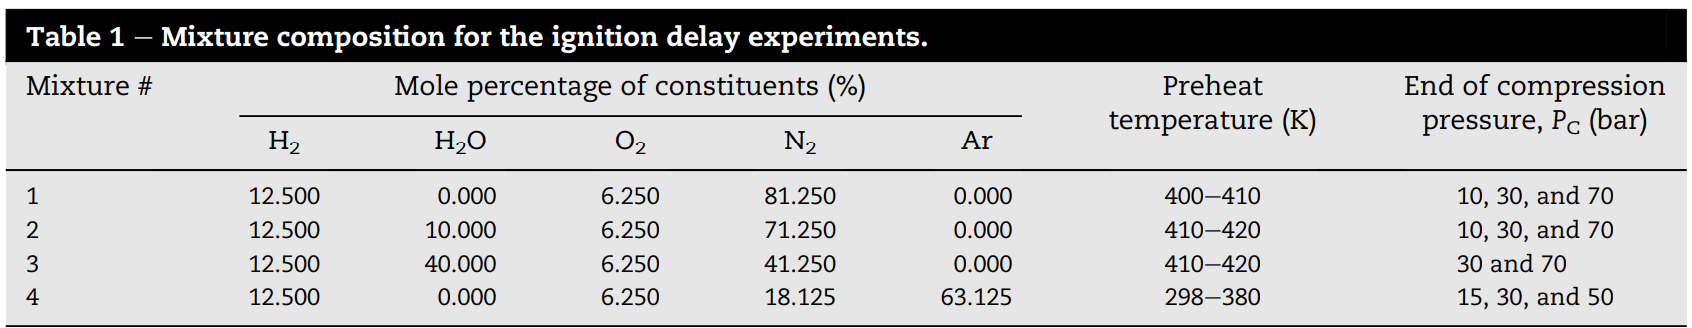

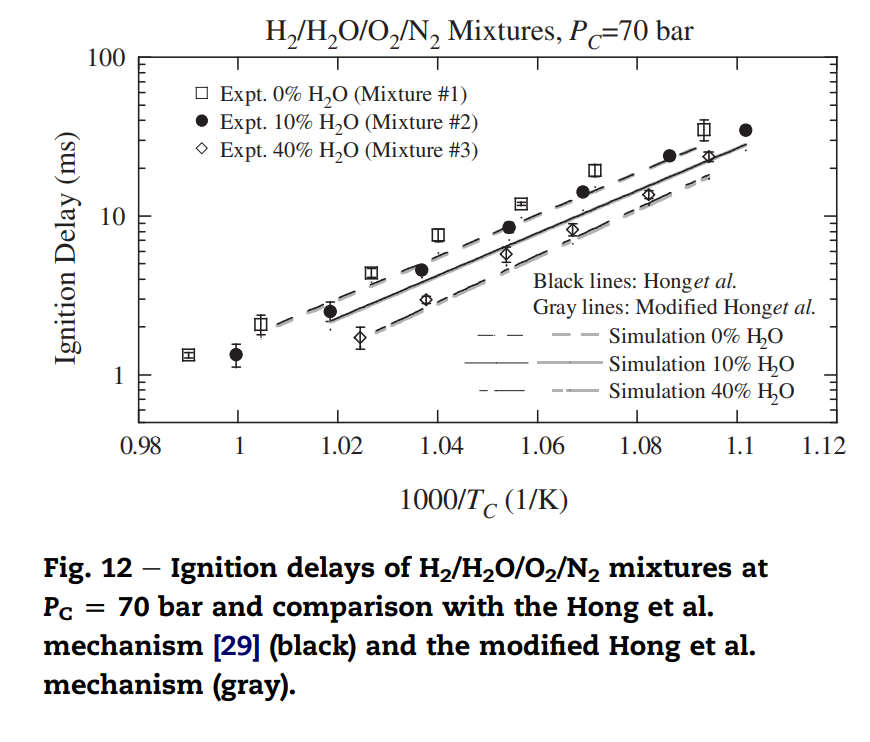

* Further reading: ["Estimation of third body efficiencies from experimental data: Application to hydrogen combustion" (Bertolino et al.)](https://drive.google.com/file/d/1b9eeWRiobquzTYwrdVpy5um8qbhHkl9T/view?usp=sharing)


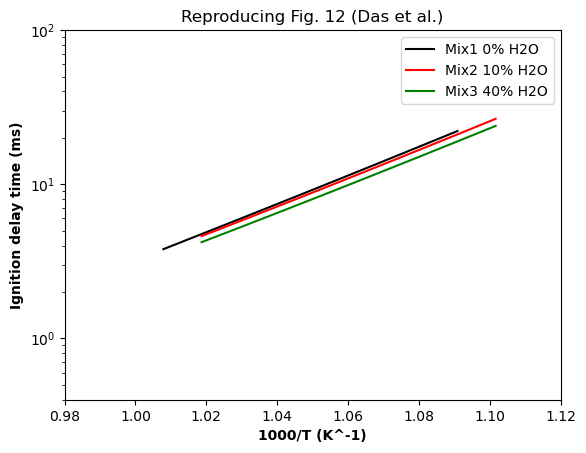

In [25]:
#REPRODUCING FIG 12
def plotIgnitionDelay_Fig12(fname,T,P,X,pltColour,pltLabel="_hidden",tConv=1e3): #tConv=1e3 converts from s to ms by default 
    refSpecies = "OH"
    estimated_ignition_delay_times = np.ones_like(T, dtype=float)
    gas = ct.Solution(fname)
    ignition_delays = ct.SolutionArray(gas, shape=T.shape, extra={"tau": estimated_ignition_delay_times})
    ignition_delays.TPX = T, P, X # [K], [Pa], [-]
    tau_list=[]
    for i, state in enumerate(ignition_delays):
        gas.TPX = state.TPX
        r = ct.Reactor(contents=gas, energy='on')
        reactor_network = ct.ReactorNet([r])
        refSpecies_history = []
        time_history = []
        t = 0
        while t < estimated_ignition_delay_times[i]:
            t = reactor_network.step()
            time_history.append(t)
            refSpecies_history.append(gas[refSpecies].X[0])
        i_ign = np.array(refSpecies_history).argmax()
        tau = time_history[i_ign]
        tau_list.append(tau) 
    plt.semilogy(1000 / ignition_delays.T, np.multiply(tConv,tau_list),'-',color=pltColour, marker=None,label=pltLabel)

plt.figure()
fname='test/data/alzuetamechanism.yaml'
P=70e5

T=np.divide(1000,np.arange(1.00789, 1.0915, 0.001))
X={'H2':0.125, 'O2':0.0625, 'H2O':0, 'N2':0.8125}
plotIgnitionDelay_Fig12(fname,T,P,X,'k',pltLabel='Mix1 0% H2O')

T=np.divide(1000,np.arange(1.018665, 1.10167, 0.001))
X={'H2':0.125, 'O2':0.0625, 'H2O':0.1, 'N2':0.7125}
plotIgnitionDelay_Fig12(fname,T,P,X,'r',pltLabel='Mix2 10% H2O')

T=np.divide(1000,np.arange(1.018665, 1.10167, 0.001))
X={'H2':0.125, 'O2':0.0625, 'H2O':0.4, 'N2':0.4125}
plotIgnitionDelay_Fig12(fname,T,P,X,'g',pltLabel='Mix3 40% H2O')

plt.title("Reproducing Fig. 12 (Das et al.)")
plt.ylabel("Ignition delay time (ms)",**hfont)
plt.xlabel(r"1000/T (K^-1)", **hfont)
plt.ylim([0.4,100])
plt.xlim([0.98,1.12])
plt.legend()
plt.show()

#### 4.2) NH3/O2/Ar mixture 
* Figure 9: ["A shock tube study of fuel concentration effect on high-pressure autoignition delay of ammonia" (Peng et al.)](https://drive.google.com/file/d/1JO1HS3WTDgLyB6KY0jVLoKAWNhu3Th0B/view?usp=sharing)

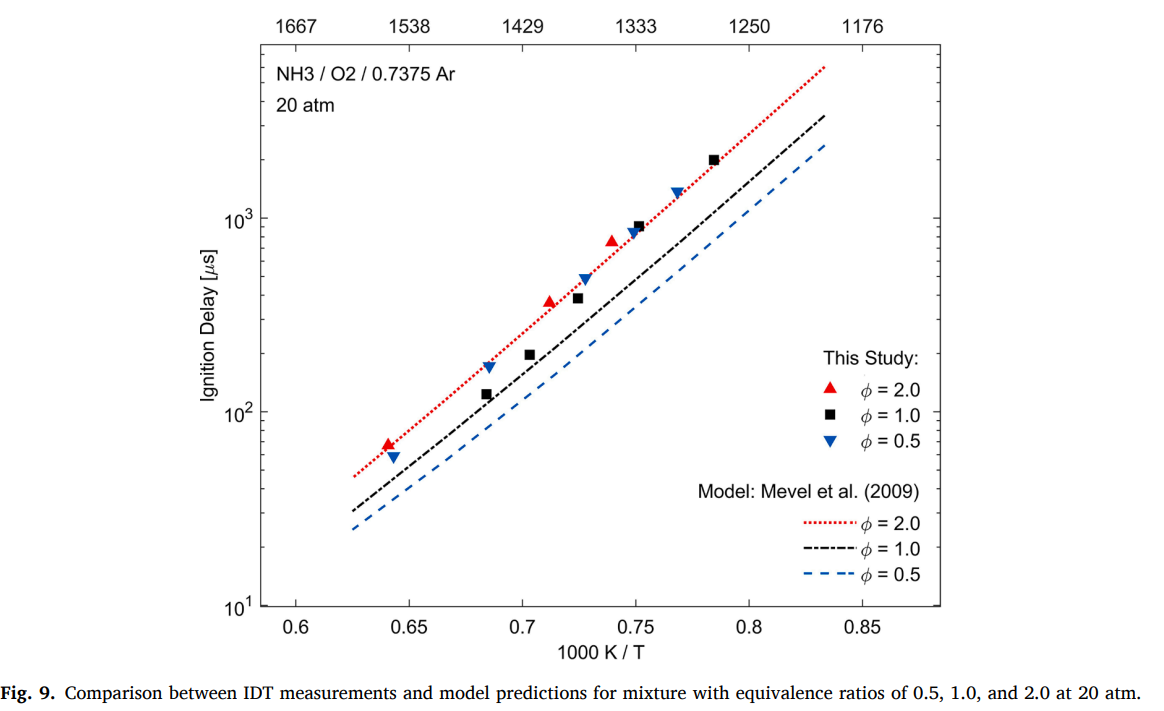

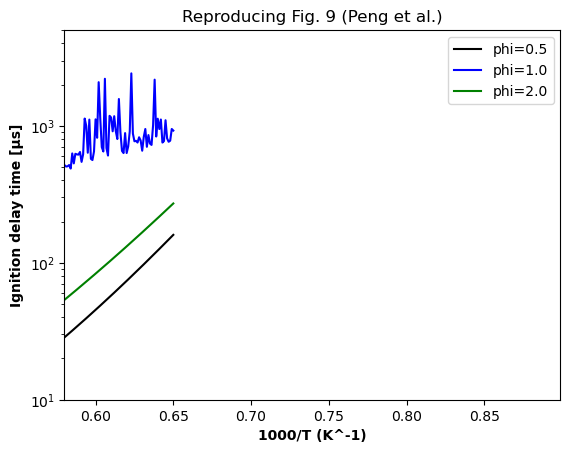

In [23]:
#REPRODUCING FIG 9
def plotIgnitionDelay_Fig9(fname,phi,pltColour,pltLabel="_hidden"): #ign delays plotted in units of μs by default
    T=np.divide(1000,np.arange(0.47, 0.65, 0.001))
    P=20*101325
    refSpecies = "O"
    estimated_ignition_delay_times = 0.7*np.ones_like(T, dtype=float)
    gas = ct.Solution(fname)
    ignition_delays = ct.SolutionArray(gas, shape=T.shape, extra={"tau": estimated_ignition_delay_times})
    ignition_delays.TP = T, P
    ignition_delays.set_equivalence_ratio(phi,'NH3','O2',diluent='Ar:1', fraction={"diluent":0.7375},basis='mole')
    tau_list=[]
    for i, state in enumerate(ignition_delays):
        gas.TPX = state.TPX
        r = ct.Reactor(contents=gas, energy='on')
        reactor_network = ct.ReactorNet([r])
        refSpecies_history = []
        time_history = []
        t = 0
        while t < estimated_ignition_delay_times[i]:
            t = reactor_network.step()
            time_history.append(t)
            refSpecies_history.append(gas[refSpecies].X[0])
        i_ign = np.array(refSpecies_history).argmax()
        tau = time_history[i_ign]
        tau_list.append(tau) 
    plt.semilogy(1000 / ignition_delays.T, np.multiply(1e6,tau_list),'-',color=pltColour, marker=None,label=pltLabel)


plt.figure()
fname='test/data/alzuetamechanism.yaml'
plotIgnitionDelay_Fig9(fname,0.5,'k',pltLabel="phi=0.5")
plotIgnitionDelay_Fig9(fname,1.0,'b',pltLabel="phi=1.0")
plotIgnitionDelay_Fig9(fname,2.0,'g',pltLabel="phi=2.0")

plt.title("Reproducing Fig. 9 (Peng et al.)")
plt.ylabel("Ignition delay time [μs]",**hfont)
plt.xlabel(r"1000/T (K^-1)", **hfont)
plt.ylim([10,5000])
plt.xlim([0.58,0.899])
plt.legend()
plt.show()

### 5) FLAME BURNING RATE PLOTS
#### 5.1) H2/O2/He mixture 
* Figure 1, 2: ["Assessment of kinetic modeling for lean H2/CH4/O2/diluent flames at high pressures" (Burke et al.)](https://drive.google.com/file/d/1SP44K4k0oS81g19Gny2TQxCgBMXFXboB/view?usp=sharing)
* Further reading: ["Evaluating Mixture Rules for Multi-Component Pressure Dependence: H+O2 (+M)=HO2 (+M)" (Burke et al.)](https://drive.google.com/file/d/1VsMwxM_VrQSqbVT4c5ARn_KthV4oLiWJ/view?usp=sharing), ["Negative pressure dependence of mass burning rates of H2/CO/O2/diluent flames at low flame temperatures" (Burke et al.)](https://drive.google.com/file/d/1vTAJ_EpAyKNhtb_uAUpahS91CbWAw3Ej/view?usp=sharing)

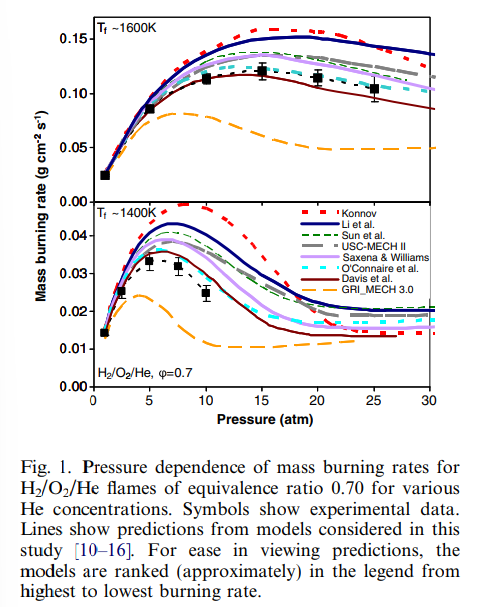


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      1.78e-06      6.167
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.175e-11      6.152
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps   
 
*******************************************************************************
CanteraError thrown by OneDim::timeStep:
Time integration failed.
*******************************************************************************
 

******** Initial solve failed; Retrying with energy equation disabled ********

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001281      2.435
Attempt Newton solution of steady-state prob

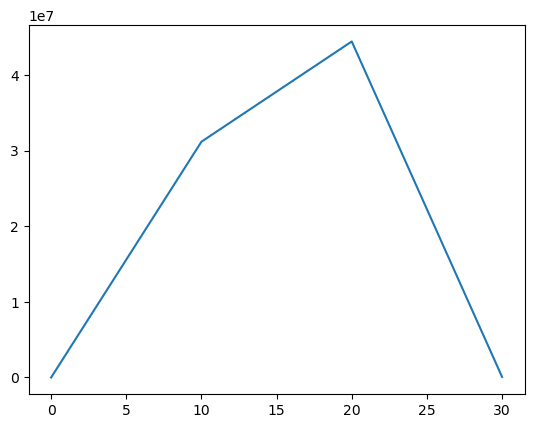

In [32]:
# REPRODUCING BURKE FIGURE 1

# I need to plot the mass burning rate, not the flame speed. How do I do this?

def plotFlameSpeed_BurkeFig1(fname,T):
    P=np.linspace(0.001,30,4)#Using a very small number of points in P array for now, because otherwise sim time would be too long
    phi=0.7
    # width=[0.08,0.03,0.015,0.008]
    width=0.03 #[m] how do we know the flame width?
    loglevel = 1 # amount of diagnostic output (0 to 8)
    fspeed=[]
    for j in range(len(P)):
        # Solution object used to compute mixture properties, set to the state of the
        # upstream fuel-air mixture
        gas = ct.Solution(fname)
        gas.TP = T, P[j]*ct.one_atm
        gas.set_equivalence_ratio(phi,'H2','O2',diluent='He:1', fraction={"diluent":0.3},basis='mole') # NOTE: DILUENT FRACTION OF 0.3 IS A PLACEHOLDER. MUST FIND REAL NUMBER.
        # Create the flame object
        f = ct.FreeFlame(gas,width=width)
        f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12) # Define tolerances for the solver
        # f.show()
        f.transport_model='multicomponent'
        f.solve(loglevel,auto=True)
        fspeed.append(f.velocity[0]) #[m/s] multicomponent flame speed
        print(f.velocity[0])
    print(fspeed)
    plt.plot(P,fspeed)
    
plt.figure()
plotFlameSpeed_BurkeFig1('test/data/alzuetamechanism.yaml',T=1400)
plotFlameSpeed_BurkeFig1('test/data/alzuetamechanism.yaml',T=1600)
plt.show()

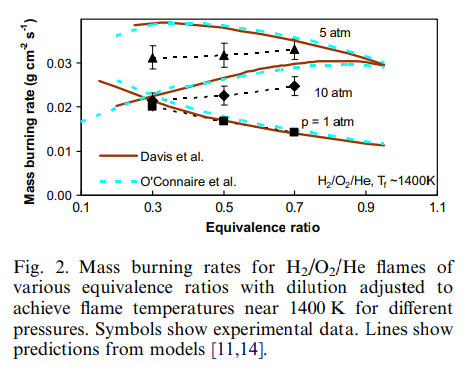

In [ ]:
# REPRODUCING BURKE FIGURE 2

# I need to plot the mass burning rate, not the flame speed. How do I do this?

def plotFlameSpeed_BurkeFig2(fname,P):
    T=1400
    phi=np.linspace(0.15,1.0,4)#Using a very small number of points in phi array for now, because otherwise sim time would be too long
    # width=[0.08,0.03,0.015,0.008]
    width=0.03 #[m] how do we know the flame width?
    loglevel = 1 # amount of diagnostic output (0 to 8)
    fspeed=[]
    for j in range(len(phi)):
        # Solution object used to compute mixture properties, set to the state of the
        # upstream fuel-air mixture
        gas = ct.Solution(fname)
        gas.TP = T, P*ct.one_atm
        gas.set_equivalence_ratio(phi[j],'H2','O2',diluent='He:1', fraction={"diluent":0.3},basis='mole') # NOTE: DILUENT FRACTION OF 0.3 IS A PLACEHOLDER. MUST FIND REAL NUMBER.
        # Create the flame object
        f = ct.FreeFlame(gas,width=width)
        f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12) # Define tolerances for the solver
        # f.show()
        f.transport_model='multicomponent'
        f.solve(loglevel,auto=True)
        fspeed.append(f.velocity[0]) #[m/s] multicomponent flame speed
        print(f.velocity[0])
    print(fspeed)
    plt.plot(phi,fspeed)

#REPRODUCING FIGURE 2
plt.figure()
plotFlameSpeed_BurkeFig2('test/data/alzuetamechanism.yaml',P=1)
plotFlameSpeed_BurkeFig2('test/data/alzuetamechanism.yaml',P=5)
plotFlameSpeed_BurkeFig2('test/data/alzuetamechanism.yaml',P=10)
plt.show()

#### 5.2) H2/H2O mixture 
* Figure 2a: ["The effects of water dilution on hydrogen, syngas, and ethylene flames at elevated pressure" (Santner et al.)](https://drive.google.com/file/d/1eijNHH4XoFlrORzyl55VKOU7b3VqTWie/view?usp=sharing)

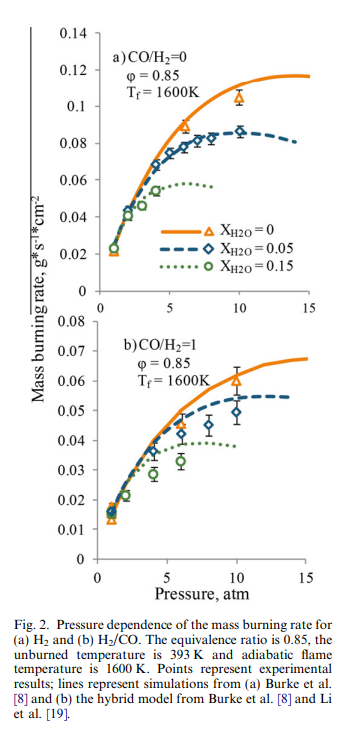

In [1]:
# REPRODUCING SANTNER FIGURE 2A

def plotFlameSpeed_SantnerFig2A(fname,X_H2O):
    P=np.linspace(0.001,30,4)#Using a very small number of points in P array for now, because otherwise sim time would be too long
    phi=0.85
    T=1600
    # width=[0.08,0.03,0.015,0.008]
    width=0.03 #[m] how do we know the flame width?
    loglevel = 1 # amount of diagnostic output (0 to 8)
    fspeed=[]
    for j in range(len(P)):
        # Solution object used to compute mixture properties, set to the state of the
        # upstream fuel-air mixture
        gas = ct.Solution(fname)
        gas.TP = T, P[j]*ct.one_atm
        gas.set_equivalence_ratio(phi,'H2','O2',diluent='H2O:1', fraction={"diluent":X_H2O},basis='mole') # NOTE: NEED TO CHECK IF THE OXIDIZER IS ACTUALLY O2
        # Create the flame object
        f = ct.FreeFlame(gas,width=width)
        f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12) # Define tolerances for the solver
        # f.show()
        f.transport_model='multicomponent'
        f.solve(loglevel,auto=True)
        fspeed.append(f.velocity[0]) #[m/s] multicomponent flame speed
        print(f.velocity[0])
    print(fspeed)
    plt.plot(P,fspeed)
    
plt.figure()
plotFlameSpeed_SantnerFig2A('test/data/alzuetamechanism.yaml',X_H2O=0.00)
plotFlameSpeed_SantnerFig2A('test/data/alzuetamechanism.yaml',X_H2O=0.05)
plotFlameSpeed_SantnerFig2A('test/data/alzuetamechanism.yaml',X_H2O=0.15)
plt.show()


KeyboardInterrupt



#### 5.3) NH3/air mixture 
* Figure 1: ["Effect of Chemistry and Transport Properties on Near-Limit Flames at Microgravity" (Paul D Ronney)](https://drive.google.com/file/d/187j_Co3Qqg4c6BtydoD7PCRcT2uURtrj/view?usp=sharing)

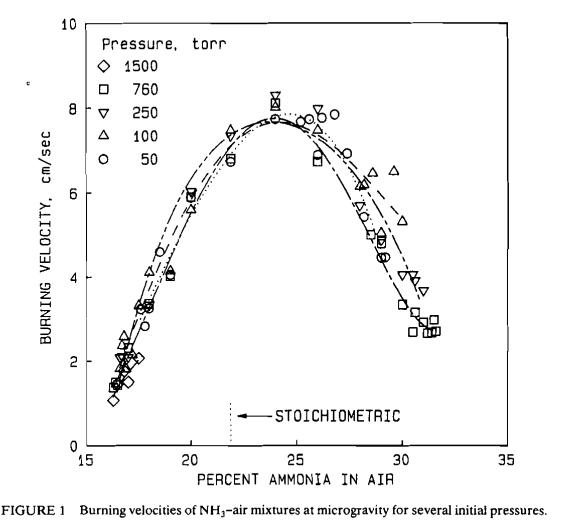

In [ ]:
# REPRODUCING RONNEY FIGURE 1

def plotFlameSpeed_RonneyFig1(fname,P):
    X_NH3=np.linspace(0.16,0.32,4)#Using a very small number of points in X_NH3 array for now, because otherwise sim time would be too long
    X_air = 1-X_NH3
    X_O2 = 1/(1+3.76)*X_air
    X_N2 = 1-X_NH3-X_O2
    T=1600 #THIS IS A PLACEHOLDER. STILL NEED TO FIND REAL VALUE OF TEMPERATURE
    width=0.03
    loglevel = 1
    fspeed=[]
    for j in range(len(X_NH3)):
        gas = ct.Solution(fname)
        gas.TP = T, P[j]*ct.one_atm
        gas.X = {'NH3':X_NH3[j],'O2':X_O2,'N2':X_N2}
        f = ct.FreeFlame(gas,width=width)
        f.set_refine_criteria(ratio=3, slope=0.06, curve=0.12)
        f.transport_model='multicomponent'
        f.solve(loglevel,auto=True)
        fspeed.append(f.velocity[0])
        print(f.velocity[0])
    print(fspeed)
    plt.plot(X_NH3,fspeed)
    
plt.figure()
plotFlameSpeed_RonneyFig1('test/data/alzuetamechanism.yaml',P=760/50)
plotFlameSpeed_RonneyFig1('test/data/alzuetamechanism.yaml',P=760/100)
plotFlameSpeed_RonneyFig1('test/data/alzuetamechanism.yaml',P=760/250)
plotFlameSpeed_RonneyFig1('test/data/alzuetamechanism.yaml',P=760/760)
plotFlameSpeed_RonneyFig1('test/data/alzuetamechanism.yaml',P=760/1500)
plt.show()